In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# %config InlineBackend.figure_format = 'retina'
# plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

# Typo - page 194, "So it's no good"
# Typo - page 196, "you did this IS (in) earlier chapters"
# Typo - page 203, "...as a measure __ model performance" (probably missing the word 'of')
# Typo - page 217, in rethinking box: "[add cite to sub paper?]"
# Typo - page 218, entire overthinking box
# Typo - page 219, "...exist that dominate AIC IS (in) every context"
# Typo - page 219, "Unfortunately, IT'S (its) generality..."
# Typo - page 221, broken figure link
# Typos - page 228, "IT'S job...IT'S job..." (two times) both should be its.
# Maybe typo, maybe style - page 233, "The same partial regression result has been found FOR GENERAL in mammals..."
# Typo - page 237, uses 'literature' and 'literatures' in the same sentence. Second should probably just be literature.

In [2]:
# R code 7.1
data = {'species':["afarensis","africanus","habilis","boisei",
                    "rudolfensis","ergaster","sapiens"],
        'brainvolcc':[438 , 452 , 612, 521, 752, 871, 1350],
        'masskg':[37.0 , 35.5 , 34.5 , 41.5 , 55.5 , 61.0 , 53.5]
       }

d=pd.DataFrame(data)
d

,species,brainvolcc,masskg
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


In [3]:
# R code 7.2
d['mass_std']= (d.masskg - d.masskg.mean())/d.masskg.std()
d['brain_std'] = d.brainvolcc/max(d.brainvolcc)
d

,species,brainvolcc,masskg,mass_std,brain_std
0,afarensis,438,37.0,-0.779467,0.324444
1,africanus,452,35.5,-0.917020,0.334815
2,habilis,612,34.5,-1.008722,0.453333
3,boisei,521,41.5,-0.366808,0.385926
4,rudolfensis,752,55.5,0.917020,0.557037
5,ergaster,871,61.0,1.421380,0.645185
6,sapiens,1350,53.5,0.733616,1.000000


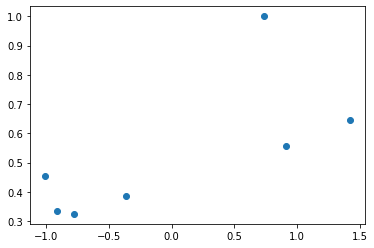

In [4]:
plt.plot(d.mass_std, d.brain_std, 'o');

In [5]:
# R code 7.3
# Simple, linear model that compares mass and brain size.
with pm.Model() as m_7_1:
    alpha = pm.Normal('alpha', mu=0.5, sd=1) 
    beta_mass = pm.Normal('beta_mass', mu=0, sd=10) 
    mu = pm.Deterministic('mu', alpha + beta_mass*d.mass_std)
    sigma = pm.Lognormal('sigma', mu=0, sd=1)
    brain = pm.Normal('brain', mu=mu, sd=sigma, observed=d.brain_std)
    trace_7_1 = pm.sample(10000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_mass, alpha]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:14<00:00, 733.14it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [6]:
varnames = ['alpha','beta_mass']
pm.summary(trace_7_1, var_names = varnames, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,0.53,0.11,0.0,0.35,0.69
beta_mass,0.17,0.13,0.0,-0.03,0.34


In [7]:
# R code 7.6
# second-degree polynomial

with pm.Model() as m_7_2:
    alpha = pm.Normal('alpha', mu=0.5, sd=1) 
    beta_mass = pm.Normal('beta_mass', mu=0, sd=10, shape=2) 
    mu = pm.Deterministic('mu', alpha + beta_mass[0]*d.mass_std 
                          + beta_mass[1]*d.mass_std**2)
    sigma = pm.Lognormal('sigma', mu=0, sd=1)
    brain = pm.Normal('brain', mu=mu, sd=sigma, observed=d.brain_std)
    trace_7_2 = pm.sample(10000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_mass, alpha]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:18<00:00, 573.36it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [8]:
with pm.Model() as m_7_3:
    alpha = pm.Normal('alpha', mu=0.5, sd=1) 
    beta_mass = pm.Normal('beta_mass', mu=0, sd=10, shape=3) 
    mu = pm.Deterministic('mu', alpha + beta_mass[0]*d.mass_std 
                          + beta_mass[1]*d.mass_std**2 + beta_mass[2]*d.mass_std**3)
    sigma = pm.Lognormal('sigma', mu=0, sd=1)
    brain = pm.Normal('brain', mu=mu, sd=sigma, observed=d.brain_std)
    trace_7_3 = pm.sample(10000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_mass, alpha]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:27<00:00, 380.65it/s]
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [9]:
with pm.Model() as m_7_4:
    alpha = pm.Normal('alpha', mu=0.5, sd=1) 
    beta_mass = pm.Normal('beta_mass', mu=0, sd=10, shape=4) 
    mu = pm.Deterministic('mu', alpha + beta_mass[0]*d.mass_std 
                          + beta_mass[1]*d.mass_std**2 + beta_mass[2]*d.mass_std**3
                         + beta_mass[3]*d.mass_std**4)
    sigma = pm.Lognormal('sigma', mu=0, sd=1)
    brain = pm.Normal('brain', mu=mu, sd=sigma, observed=d.brain_std)
    trace_7_4 = pm.sample(10000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_mass, alpha]
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:47<00:00, 223.02it/s]
There were 1654 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5551544318993467, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [10]:
with pm.Model() as m_7_5:
    alpha = pm.Normal('alpha', mu=0.5, sd=1) 
    beta_mass = pm.Normal('beta_mass', mu=0, sd=10, shape=5) 
    mu = pm.Deterministic('mu', alpha + beta_mass[0]*d.mass_std 
                          + beta_mass[1]*d.mass_std**2 + beta_mass[2]*d.mass_std**3
                         + beta_mass[3]*d.mass_std**4 +beta_mass[4]*d.mass_std**5)
    sigma = pm.Lognormal('sigma', mu=0, sd=1)
    brain = pm.Normal('brain', mu=mu, sd=sigma, observed=d.brain_std)
    trace_7_5 = pm.sample(10000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_mass, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 10500/10500 [02:19<00:00, 75.29it/s]
There were 1446 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.645830042561364, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [11]:
# R code 7.8 - sigma = 0.001 (forced)
with pm.Model() as m_7_6:
    alpha = pm.Normal('alpha', mu=0.5, sd=1) 
    beta_mass = pm.Normal('beta_mass', mu=0, sd=10, shape=6) 
    mu = pm.Deterministic('mu', alpha + beta_mass[0]*d.mass_std 
                          + beta_mass[1]*d.mass_std**2 + beta_mass[2]*d.mass_std**3
                         + beta_mass[3]*d.mass_std**4 +beta_mass[4]*d.mass_std**5
                         + beta_mass[5]*d.mass_std**6)
    sigma = 0.001
    brain = pm.Normal('brain', mu=mu, sd=sigma, observed=d.brain_std)
    trace_7_6 = pm.sample(10000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta_mass, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 10500/10500 [08:06<00:00, 16.11it/s]
The acceptance probability does not match the target. It is 0.6484988498502707, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [12]:
trace_7_1['mu'].shape  # >(10000, 7) one row for each posterior sample, one column for each
# piece of data

trace_7_1['mu'].mean(1).shape # > (10000,) this calculates the mean mu for each sample.

trace_7_1['beta_mass'].shape # (10000, )
trace_7_2['beta_mass'].shape # (10000, 2)
trace_7_2['beta_mass'][0].shape # (2, )
trace_7_2['beta_mass'][:,0].shape # (10000, )


(10000,)

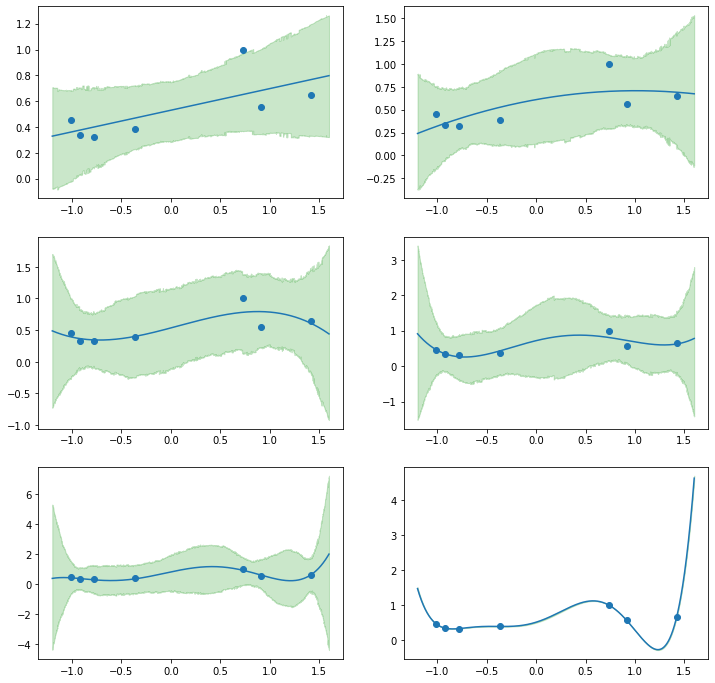

In [13]:
x=np.linspace(-1.2,1.6,10000)
f = plt.figure(figsize=(12,12))

ax1=f.add_subplot(321)
ax1.plot(d.mass_std, d.brain_std, 'o')
mu_pred = trace_7_1['alpha'] + trace_7_1['beta_mass'] * x[:,None]
ax1.plot(x, mu_pred.mean(1), 'C0')
mu_hpd = pm.hpd(mu_pred.T)
ax1.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)

ax2=f.add_subplot(322)
ax2.plot(d.mass_std, d.brain_std, 'o')
mu_pred = (trace_7_2['alpha'] + trace_7_2['beta_mass'][:,0]* x[:,None] 
           + trace_7_2['beta_mass'][:,1] * x[:,None]**2)
ax2.plot(x, mu_pred.mean(1), 'C0')
mu_hpd = pm.hpd(mu_pred.T)
ax2.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)

ax3=f.add_subplot(323)
ax3.plot(d.mass_std, d.brain_std, 'o')
mu_pred = (trace_7_3['alpha'] + trace_7_3['beta_mass'][:,0]* x[:,None] 
           + trace_7_3['beta_mass'][:,1] * x[:,None]**2 
           + trace_7_3['beta_mass'][:,2] * x[:,None]**3)
ax3.plot(x, mu_pred.mean(1), 'C0')
mu_hpd = pm.hpd(mu_pred.T)
ax3.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)

ax4=f.add_subplot(324)
ax4.plot(d.mass_std, d.brain_std, 'o')
mu_pred = (trace_7_4['alpha'] + trace_7_4['beta_mass'][:,0]* x[:,None] 
           + trace_7_4['beta_mass'][:,1] * x[:,None]**2 
           + trace_7_4['beta_mass'][:,2] * x[:,None]**3
           + trace_7_4['beta_mass'][:,3] * x[:,None]**4)
ax4.plot(x, mu_pred.mean(1), 'C0')
mu_hpd = pm.hpd(mu_pred.T)
ax4.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)

ax5=f.add_subplot(325)
ax5.plot(d.mass_std, d.brain_std, 'o')
mu_pred = (trace_7_5['alpha'] + trace_7_5['beta_mass'][:,0]* x[:,None] 
           + trace_7_5['beta_mass'][:,1] * x[:,None]**2 
           + trace_7_5['beta_mass'][:,2] * x[:,None]**3
           + trace_7_5['beta_mass'][:,3] * x[:,None]**4
           + trace_7_5['beta_mass'][:,4] * x[:,None]**5)
ax5.plot(x, mu_pred.mean(1), 'C0')
mu_hpd = pm.hpd(mu_pred.T)
ax5.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)

ax6=f.add_subplot(326)
ax6.plot(d.mass_std, d.brain_std, 'o')
mu_pred = (trace_7_6['alpha'] + trace_7_6['beta_mass'][:,0]* x[:,None] 
           + trace_7_6['beta_mass'][:,1] * x[:,None]**2 
           + trace_7_6['beta_mass'][:,2] * x[:,None]**3
           + trace_7_6['beta_mass'][:,3] * x[:,None]**4
           + trace_7_6['beta_mass'][:,4] * x[:,None]**5
           + trace_7_6['beta_mass'][:,5] * x[:,None]**6)
ax6.plot(x, mu_pred.mean(1), 'C0')
mu_hpd = pm.hpd(mu_pred.T)
ax6.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);

# Overfitting is bad. There's something wrong with the sixth graph, probably having to do
# with the sigma value and how PyMC3 differs from R, but I'm not going to worry about it.

In [14]:
# R code 7.11
with pm.Model() as m_7_7:
    alpha = pm.Normal('alpha', mu=0.5, sd=1) 
    mu = pm.Deterministic('mu', alpha)
    sigma = pm.Lognormal('sigma', mu=0, sd=1)
    brain = pm.Normal('brain', mu=mu, sd=sigma, observed=d.brain_std)
    trace_7_7 = pm.sample(10000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, alpha]
100%|██████████████████████████████████████████████████████████████████████████| 10500/10500 [00:06<00:00, 1582.73it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


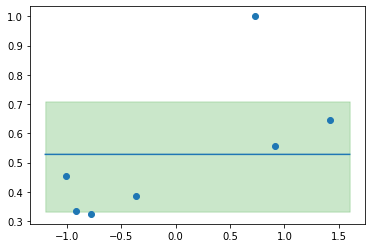

In [15]:
# Figure 7.4
x=np.linspace(-1.2,1.6,10000)

plt.plot(d.mass_std, d.brain_std, 'o')
mu_pred = trace_7_7['alpha'] + 0* x[:,None] # there has to be a better way to do this part.
plt.plot(x, mu_pred.mean(1), 'C0')
mu_hpd = pm.hpd(mu_pred.T, alpha=0.11)
plt.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);

In [16]:
# R code 7.14

waic_7_1 = pm.waic(trace_7_1, m_7_1)
waic_7_1.WAIC

C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1.9193504571006468

In [295]:
# R code 7.20
# I think this part is going to be important to understand.
d1 = pd.read_csv('Data/cars.csv', sep=',', header=0)

In [275]:
# Creating the model - standard stuff.
with pm.Model() as m_7_8:
    alpha = pm.Normal('alpha', mu=0, sd=100) 
    beta = pm.Normal('beta', mu=0, sd=10)
    mu = pm.Deterministic('mu', alpha + beta*d1.speed)
    sigma = pm.Lognormal('sigma', mu=0, sd=1)
    distance = pm.Normal('distance', mu=mu, sd=sigma, observed=d1.dist)
    trace_7_8 = pm.sample(1000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha]
100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 830.93it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


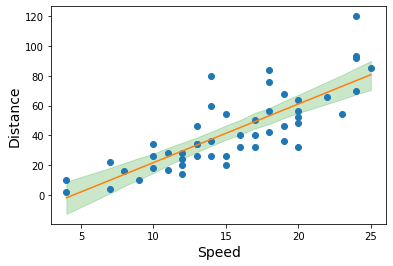

In [276]:
# Let's visualize the data and prediction.

mu_mean = trace_7_8['mu']
mu_hpd = pm.hpd(mu_mean, alpha=0.03)
x = np.linspace(4, 25, 1000)
plt.plot(d1.speed, d1.dist, 'o')
plt.plot(x, trace_7_8['alpha'].mean() + trace_7_8['beta'].mean()*x)

idx = np.argsort(d1.speed)
plt.fill_between(d1.speed, mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('Speed', fontsize=14)
plt.ylabel('Distance', fontsize=14);


In [277]:
# R code 7.21
# https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_06.ipynb
n_samples = 1000
n_observations = d1.shape[0]
logp = np.zeros((n_observations, n_samples))

# What we're going to do now is, for each sample from the posterior, work out the log 
# likelihood of each observation in the initial data set. That is, we're measuring how
# consistent the initial data set is with the model. We know the answer is "pretty
# good," because that's why the model came up with the coefficients it did. But now 
# we're quantifying "pretty good."

for s in range(0,n_samples): # for each sample from the posterior we're checking
    mu = trace_7_8['alpha'][s] + trace_7_8['beta'][s] * d1['speed'] # returns a 50x1 array, one column for each data point, of the predicted distance given the speed
    p_ = stats.norm.logpdf(d1['dist'], loc=mu, scale=trace_7_8['sigma'][s]) # this is the way of getting the log value of the prediction. It must be a distribution, because everything in this world is a distribution.
    logp[:,s] = p_ # we end up with each row being a data point, and each column being a sample

In [278]:
# R code 7.22

from scipy.special import logsumexp

n_cases = d1.shape[0] # number of rows in d1, e.g. number of data points
lppd = np.zeros((n_cases)) # I still don't understand why we have to fill this thing with zeros - maybe it's cleaner than just doing append
for a in range(1, n_cases):
    lppd[a,] = logsumexp(logp[a,]) - np.log(n_samples) # We have to do the averaging on the log scale. Not sure why - probably some computer science reason.
lppd.sum()

-202.7077385969985

In [279]:
# R code 7.23
# Now computing the penalty term.
pWAIC = np.zeros((n_cases))
for a in range(1, n_cases):
    pWAIC[a] = np.var(logp[a]) # This just computes the variance of each row in logp.

In [280]:
# R code 7.24
# Computing WAIC:
WAIC = -2*(lppd.sum() - pWAIC.sum())
WAIC

412.90737653352744

In [281]:
# R code 7.25
# There will be variance in the above result due to sampling from the posterior, but the variance is
# smaller than the standard error of WAIC itself, as shown below:
WAIC_vector = -2*(lppd - pWAIC)
np.sqrt(n_cases*np.var(WAIC_vector))

16.129808026585668

In [282]:
# All of the above stuff was an exercise, as we can get everything we need from a PyMC3 method easily:
cars_waic = pm.waic(trace_7_8, m_7_8)
cars_waic.WAIC
# The fact that this number differs from the one above isn't concerning. Absolute WAIC isn't important. 
# We only care about the WAIC scores for competing models.

C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


420.3744720949668

In [26]:
# Bringing lots of code from chapter 6 to help with the next bit

#R code 6.14

N = 100 # number of plants
h_0 = stats.norm.rvs(loc=10, scale=2, size = N) #simulate initial heights
treatment = np.repeat([0,1], [N/2]) #treat half the plants
fungus = stats.binom.rvs(size = N, n=1, p=(0.5 -  treatment*0.4)) # fungus results
h_1 = h_0 + stats.norm.rvs(size=N, loc=(5-3*fungus)) #final height
d = pd.DataFrame({'h_0': h_0,
                  'h_1': h_1,
                  'treatment':treatment,
                  'fungus': fungus})

#this 'data' will inform our priors for the next model

#R code 6.16
with pm.Model() as m_6_6:
    p = pm.Lognormal('proportion', mu=0, sd=0.25) 
    mu = pm.Deterministic('mu', p*d.h_0)
    sigma = pm.Exponential('sigma', 1)
    h_1 = pm.Normal('h_1', mu=mu, sd=sigma, observed=d.h_1)
    trace_6_6 = pm.sample(1000, tune=1000, chains=1) 
    
#R code 6.17
with pm.Model() as m_6_7:
    alpha = pm.Lognormal('alpha', mu=0, sd=0.25) #note alpha here is the old p
    beta_treatment = pm.Normal('beta_treatment', mu=0, sd=0.5) 
    beta_fungus = pm.Normal('beta_fungus', mu=0, sd=0.5) 
    p = pm.Deterministic('proportion', alpha + beta_treatment * d.treatment + beta_fungus * d.fungus)
    mu = pm.Deterministic('mu', p*d.h_0)
    sigma = pm.Exponential('sigma', 1)
    h_1 = pm.Normal('h_1', mu=mu, sd=sigma, observed=d.h_1)
    trace_6_7 = pm.sample(1000, tune=1000, chains=1) 

with pm.Model() as m_6_8:
    alpha = pm.Lognormal('alpha', mu=0, sd=0.25) #note alpha here is the old p
    beta_treatment = pm.Normal('beta_treatment', mu=0, sd=0.5) 
    p = pm.Deterministic('proportion', alpha + beta_treatment * d.treatment)
    mu = pm.Deterministic('mu', p*d.h_0)
    sigma = pm.Exponential('sigma', 1)
    h_1 = pm.Normal('h_1', mu=mu, sd=sigma, observed=d.h_1)
    trace_6_8 = pm.sample(1000, tune=1000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, proportion]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1480.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_fungus, beta_treatment, alpha]
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 844.19it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_treatment, alpha]
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 831.12it/s]
Only one ch

In [27]:
# R code 7.26 and 7.27

m_6_6.name = 'only height dependency'
m_6_7.name = 'treatment and fungus'
m_6_8.name = 'treatment only'
df_comp_WAIC = pm.compare({m_6_6: trace_6_6, m_6_7: trace_6_7, m_6_8: trace_6_8})
df_comp_WAIC

C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
     

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
treatment and fungus,334.68,3.64,0,0.97,14.43,0,1
treatment only,403.31,2.77,68.63,0.03,13.49,15.49,1
only height dependency,414.5,1.55,79.82,0,10.98,14.12,0


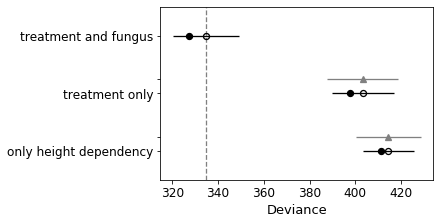

In [28]:
# R code 7.30

pm.compareplot(df_comp_WAIC);

In [29]:
# R code 7.33

d2 = pd.read_csv('Data/primates301.csv', sep=';', header=0)

In [30]:
# R code 7.34

d2['log_L']=(np.log(d2.longevity) - np.log(d2.longevity).mean())/np.log(d2.longevity).std()
d2['log_B']=(np.log(d2.brain) - np.log(d2.brain).mean())/np.log(d2.brain).std()
d2['log_M']=(np.log(d2.body) - np.log(d2.body).mean())/np.log(d2.body).std()

In [31]:
# R code 7.35
d2.isnull().sum()
# I'm sure there's a way to return only values for certain columns

name                     0
genus                    0
species                  0
subspecies             267
spp_id                   0
genus_id                 0
social_learning         98
research_effort        115
brain                  117
body                    63
group_size             114
gestation              161
weaning                185
longevity              181
sex_maturity           194
maternal_investment    197
log_L                  181
log_B                  117
log_M                   63
dtype: int64

In [32]:
# R code 7.36
d2 = d2.drop(d2[d2['brain'].isnull()].index)
d2 = d2.drop(d2[d2['body'].isnull()].index)
d2 = d2.drop(d2[d2['longevity'].isnull()].index)

In [33]:
# R code 7.37
with pm.Model() as m_7_8:
    alpha = pm.Normal('alpha', mu=0, sd=0.1) 
    beta_B = pm.Normal('beta_B', mu=0, sd=0.5) 
    beta_M = pm.Normal('beta_M', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_B * d2.log_B + beta_M * d2.log_M)
    sigma = pm.Exponential('sigma', 1)
    log_L = pm.Normal('log_L', mu=mu, sd=sigma, observed=d2.log_L)
    trace_7_8 = pm.sample(5000, tune=1000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_M, beta_B, alpha]
100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:12<00:00, 463.25it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [34]:
# R code 7.38
with pm.Model() as m_7_9:
    alpha = pm.Normal('alpha', mu=0, sd=0.1) 
    beta_B = pm.Normal('beta_B', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_B * d2.log_B)
    sigma = pm.Exponential('sigma', 1)
    log_L = pm.Normal('log_L', mu=mu, sd=sigma, observed=d2.log_L)
    trace_7_9 = pm.sample(5000, tune=1000, chains=1) 
    
with pm.Model() as m_7_10:
    alpha = pm.Normal('alpha', mu=0, sd=0.1) 
    beta_M = pm.Normal('beta_M', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_M * d2.log_M)
    sigma = pm.Exponential('sigma', 1)
    log_L = pm.Normal('log_L', mu=mu, sd=sigma, observed=d2.log_L)
    trace_7_10= pm.sample(5000, tune=1000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_B, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1234.88it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_M, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1269.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [35]:
# R code 7.39
m_7_8.name = 'both beta_B and beta_M'
m_7_9.name = 'beta_B only'
m_7_10.name = 'beta_M only'
comp_WAIC = pm.compare({m_7_8: trace_7_8, m_7_9: trace_7_9, m_7_10: trace_7_10})
comp_WAIC

C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
both beta_B and beta_M,216.08,3.23,0,0.55,14.02,0,0
beta_B only,216.13,2.35,0.05,0.45,14.18,1.32,0
beta_M only,229.27,2.37,13.19,0,15.77,6.66,0


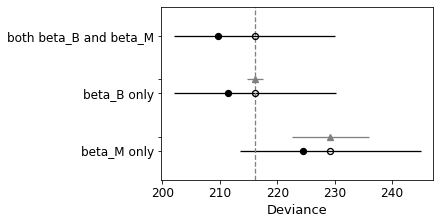

In [36]:
# R code 7.40
pm.compareplot(comp_WAIC);

C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\arviz\plots\forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\arviz\plots\forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


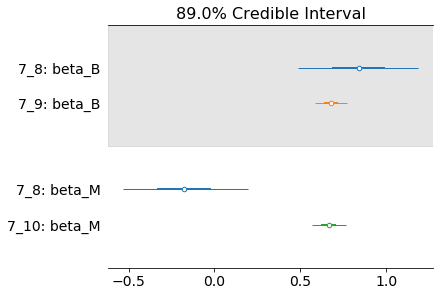

In [37]:
# R code 7.41
varnames = ['beta_B', 'beta_M']
pm.forestplot((trace_7_8, trace_7_9, trace_7_10), model_names = ("7_8","7_9","7_10"), 
              var_names=varnames, credible_interval=0.89, linewidth=1, figsize=(6,4));
# Width of distributions in model 7_8 is caused by colinearity

In [38]:
# R code 7.42
covariance = np.corrcoef(d2['log_B'], d2['log_M'])
covariance

array([[1.        , 0.97962718],
       [0.97962718, 1.        ]])

In [39]:
# R code 7.43
waic_m_7_8 = pm.waic(trace_7_8, model=m_7_8, pointwise=True)
waic_m_7_9 = pm.waic(trace_7_9, model=m_7_9, pointwise=True)

C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


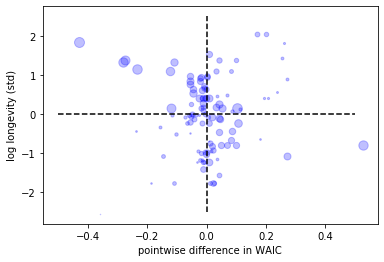

In [40]:
# R code 7.44
# The first 4 lines are used to scale the size of the markers relative to the differences of the logs of B and M.
# Large dots mean "big brains for body size."
x = (d2['log_B'].values-d2['log_M'].values)
x = x - x.min()
scaled_sizes = x/x.max()
scaled_sizes = scaled_sizes*10 # this line is necessary because of the differences between python and R

# If there's a way to take marker size as an array/list, I can't figure it out. So we have to plot the points 
# one at a time.
for i in range(0, scaled_sizes.shape[0]):
    plt.plot(waic_m_7_8[4][i] - waic_m_7_9[4][i], d2['log_L'].values[i], 'ob', markersize=scaled_sizes[i], alpha=0.25)

plt.plot((0,0), (-2.5,2.5), 'k--')
plt.plot((-0.5,0.5), (0,0), 'k--')
plt.xlabel("pointwise difference in WAIC")
plt.ylabel("log longevity (std)");

# The conclusion is that the models, while equal in terms of WAIC evaluation, are not equal in that they make
# very different predictions about different primates.

In [41]:
# R code 7.45
# This model is based on a reversed DAG, where long life causes brain size rather than the other way around.
with pm.Model() as m_7_11:
    alpha = pm.Normal('alpha', mu=0, sd=0.1) 
    beta_M = pm.Normal('beta_M', mu=0, sd=0.5) 
    beta_L = pm.Normal('beta_L', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_M * d2.log_M + beta_L * d2.log_L)
    sigma = pm.Exponential('sigma', 1)
    log_B = pm.Normal('log_B', mu=mu, sd=sigma, observed=d2.log_B)
    trace_7_11= pm.sample(5000, tune=1000, chains=1) 

varnames = ['alpha', 'beta_M', 'beta_L', 'sigma']
pm.summary(trace_7_11, var_names = varnames, alpha = 0.11).round(2)

# The results are equally plausible.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_L, beta_M, alpha]
100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:06<00:00, 902.04it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,-0.04,0.02,0.0,-0.08,-0.02
beta_M,0.94,0.03,0.0,0.90,0.98
beta_L,0.12,0.03,0.0,0.07,0.16
sigma,0.19,0.01,0.0,0.17,0.22


In [42]:
# 7E1
# Point 1: continuity of uncertainty. If the uncertainty is, say, piecewise instead of continuous, that wouldn't
# any sense. A small change in probability could cause a large change in uncertainty. I can't think of a physical
# system that works that way.
# Point 2: If there are more possible events, the amount of uncertainty increases. The same principle applies in
# physics. If you have more microstates, we increase the number of ways to end up with a given macrostate.
# Point 3: Uncertainty should be additive. I don't have a good grasp of why this should be true. I know what it means,
# and I know how to use it, but I don't have a good grasp on why it should be true a priori.

In [43]:
# 7E2 - If you're using a calculator, remember log means ln
H = -(0.7*np.log(0.7) + 0.3*np.log(0.3))
H

0.6108643020548935

In [44]:
# 7E3
H = -(0.2*np.log(0.2) + 2*0.25*np.log(0.25) + 0.3*np.log(0.3))
H

1.3762266043445461

In [45]:
# 7E4
H = -(3*(1/3)*np.log(1/3))
H

1.0986122886681098

In [46]:
# 7M1
# AIC requires a specific sort of prior distribution (flat) and posterior distribution (multivariate Gaussian).
# DIC allows more general priors, but still requires a multivariate Gaussian posterior. It, like AIC, requires that
# the number of  samples is much greater than the number of parameters.
# WAIC is the most general. It requires nothing special of the posterior.

In [47]:
# 7M2
# Model selection implies we're choosing one model that is "best" and discarding the rest. Model averaging appreciates
# that certain models are more appropriate for making certain types of predictions and, presumably, can be used
# to do that, though we have no practice averaging models at this point. When we practice model selection, we lose 
# valuable information about how much better one model is that another. I'm not sure what we lose by model averaging - 
# maybe simplicity? Model averaging is not covered in depth in the text.

In [48]:
# 7M3
# If we fit to a different number of samples, that means a different entropy due to the definition of energy, summing
# over all possible observations. Different entropy will mean different model scores.

In [49]:
# 7M4
# The effective number of parameters is pWAIC in the WAIC evaluation. We'll use the fungus model conditioned on both 
# treatment and fungus and change the priors for both beta values.

# R code 7.37
with pm.Model() as m_7M4_1:
    alpha = pm.Lognormal('alpha', mu=0, sd=0.25) #note alpha here is the old p
    beta_treatment = pm.Normal('beta_treatment', mu=0, sd=20) 
    beta_fungus = pm.Normal('beta_fungus', mu=0, sd=20) 
    p = pm.Deterministic('proportion', alpha + beta_treatment * d.treatment + beta_fungus * d.fungus)
    mu = pm.Deterministic('mu', p*d.h_0)
    sigma = pm.Exponential('sigma', 1)
    h_1 = pm.Normal('h_1', mu=mu, sd=sigma, observed=d.h_1)
    trace_7M4_1 = pm.sample(5000, tune=1000, chains=1) 

with pm.Model() as m_7M4_2:
    alpha = pm.Lognormal('alpha', mu=0, sd=0.25) #note alpha here is the old p
    beta_treatment = pm.Normal('beta_treatment', mu=0, sd=5) 
    beta_fungus = pm.Normal('beta_fungus', mu=0, sd=5) 
    p = pm.Deterministic('proportion', alpha + beta_treatment * d.treatment + beta_fungus * d.fungus)
    mu = pm.Deterministic('mu', p*d.h_0)
    sigma = pm.Exponential('sigma', 1)
    h_1 = pm.Normal('h_1', mu=mu, sd=sigma, observed=d.h_1)
    trace_7M4_2 = pm.sample(5000, tune=1000, chains=1)     

with pm.Model() as m_7M4_3:
    alpha = pm.Lognormal('alpha', mu=0, sd=0.25) #note alpha here is the old p
    beta_treatment = pm.Normal('beta_treatment', mu=0, sd=0.5) 
    beta_fungus = pm.Normal('beta_fungus', mu=0, sd=0.5) 
    p = pm.Deterministic('proportion', alpha + beta_treatment * d.treatment + beta_fungus * d.fungus)
    mu = pm.Deterministic('mu', p*d.h_0)
    sigma = pm.Exponential('sigma', 1)
    h_1 = pm.Normal('h_1', mu=mu, sd=sigma, observed=d.h_1)
    trace_7M4_3 = pm.sample(5000, tune=1000, chains=1) 

m_7M4_1.name = 'weakly informative'
m_7M4_2.name = 'mildly informative'
m_7M4_3.name = 'strongly informative'
comp_WAIC = pm.compare({m_7M4_1: trace_7M4_1, m_7M4_2: trace_7M4_2, m_7M4_3: trace_7M4_3})
comp_WAIC

# It seems like informative priors increase the pWAIC term. I'm not sure I conceptually understand that.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_fungus, beta_treatment, alpha]
100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 759.18it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_fungus, beta_treatment, alpha]
100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:06<00:00, 921.45it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_fungus, beta_treatment, alpha]
100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
weakly informative,334.96,3.8,0,1,14.52,0,1
strongly informative,335.08,3.87,0.12,0,14.55,0.1,1
mildly informative,335.25,3.93,0.29,0,14.53,0.04,1


In [50]:
# 7M5
# If a prior becomes more informative, the deviance of the in-sample (training) data gets worse, but the deviance
# of the out-of-sample data (testing) gets better. With skeptical priors, the model won't "learn too much" from 
# the data; this reduces fluctuations between observations. E.g., with skeptical priors, in the 5th-order polynomial
# model, the coefficients of the x^5 term will be very close to zero.

In [232]:
# 7M6
# If the priors are too informative (restrictive), then the model is hamstrung and not allowed to learn from the
# data. Therefore, the model will be underfit.

In [289]:
# 7H-All, importing data

d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d['age_std']= (d.age - d.age.mean())/d.age.std()
mask = np.random.rand(len(d)) <= 0.5
d1 = d[mask]
d2 = d[~mask]


In [233]:
# 7H-All, setting up models

with pm.Model() as m_7H_1:
    alpha = pm.Normal('alpha', mu=178, sd=30) 
    beta_age = pm.Normal('beta_age', mu=0, sd=10) 
    mu = pm.Deterministic('mu', alpha + beta_age*d1.age_std)
    sigma = pm.Lognormal('sigma', mu=0, sd=1)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d1.height)
    trace_7H_1 = pm.sample(1000, chains=1) 

with pm.Model() as m_7H_2:
    alpha = pm.Normal('alpha', mu=178, sd=30) 
    beta_age = pm.Normal('beta_age', mu=0, sd=10, shape=2) 
    mu = pm.Deterministic('mu', alpha + beta_age[0]*d1.age_std 
                          + beta_age[1]*d1.age_std**2)
    sigma = pm.Lognormal('sigma', mu=0, sd=1)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d1.height)
    trace_7H_2 = pm.sample(1000, chains=1)   
    
with pm.Model() as m_7H_3:
    alpha = pm.Normal('alpha', mu=178, sd=30) 
    beta_age = pm.Normal('beta_age', mu=0, sd=10, shape=3) 
    mu = pm.Deterministic('mu', alpha + beta_age[0]*d1.age_std 
                          + beta_age[1]*d1.age_std**2 + beta_age[2]*d1.age_std**3)
    sigma = pm.Lognormal('sigma', mu=0, sd=1)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d1.height)
    trace_7H_3 = pm.sample(1000, chains=1)     

with pm.Model() as m_7H_4:
    alpha = pm.Normal('alpha', mu=178, sd=30) 
    beta_age = pm.Normal('beta_age', mu=0, sd=10, shape=4) 
    mu = pm.Deterministic('mu', alpha + beta_age[0]*d1.age_std 
                          + beta_age[1]*d1.age_std**2 + beta_age[2]*d1.age_std**3
                         + beta_age[3]*d1.age_std**4)
    sigma = pm.Lognormal('sigma', mu=0, sd=1)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d1.height)
    trace_7H_4 = pm.sample(1000, chains=1) 
    
with pm.Model() as m_7H_5:
    alpha = pm.Normal('alpha', mu=178, sd=30) 
    beta_age = pm.Normal('beta_age', mu=0, sd=10, shape=5) 
    mu = pm.Deterministic('mu', alpha + beta_age[0]*d1.age_std 
                          + beta_age[1]*d1.age_std**2 + beta_age[2]*d1.age_std**3
                         + beta_age[3]*d1.age_std**4 +beta_age[4]*d1.age_std**5)
    sigma = pm.Lognormal('sigma', mu=0, sd=1)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d1.height)
    trace_7H_5 = pm.sample(1000, chains=1) 

with pm.Model() as m_7H_6:
    alpha = pm.Normal('alpha', mu=178, sd=30) 
    beta_age = pm.Normal('beta_age', mu=0, sd=10, shape=6) 
    mu = pm.Deterministic('mu', alpha + beta_age[0]*d1.age_std 
                          + beta_age[1]*d1.age_std**2 + beta_age[2]*d1.age_std**3
                         + beta_age[3]*d1.age_std**4 +beta_age[4]*d1.age_std**5
                         + beta_age[5]*d1.age_std**6)
    sigma = pm.Lognormal('sigma', mu=0, sd=1)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d1.height)
    trace_7H_6 = pm.sample(1000, chains=1) 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_age, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1614.91it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_age, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1194.13it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_age, alpha]
100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 756.40it/s]
Only one chain was sampled, thi

In [234]:
# 7H1

m_7H_1.name = 'first order'
m_7H_2.name = 'second order'
m_7H_3.name = 'third order'
m_7H_4.name = 'fourth order'
m_7H_5.name = 'fifth order'
m_7H_6.name = 'sixth order'
comp_WAIC = pm.compare({m_7H_1: trace_7H_1, m_7H_2: trace_7H_2, m_7H_3: trace_7H_3,
                       m_7H_4: trace_7H_4, m_7H_5: trace_7H_5, m_7H_6: trace_7H_6})
comp_WAIC

C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
C:\Users\mikev\Anaconda3\envs\stats\lib\site-packages\pymc3\stats.p

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
fourth order,1899.96,5.56,0,0.98,23.65,0,1
sixth order,1901.24,6.62,1.29,0,23.5,1.61,1
fifth order,1902.03,6.36,2.07,0,23.55,1.2,1
third order,1949.78,6.7,49.82,0,23.56,15.45,1
second order,2128.95,5.15,228.99,0.02,22.05,27.12,1
first order,2410.06,3.47,510.1,0,22.91,31.46,0


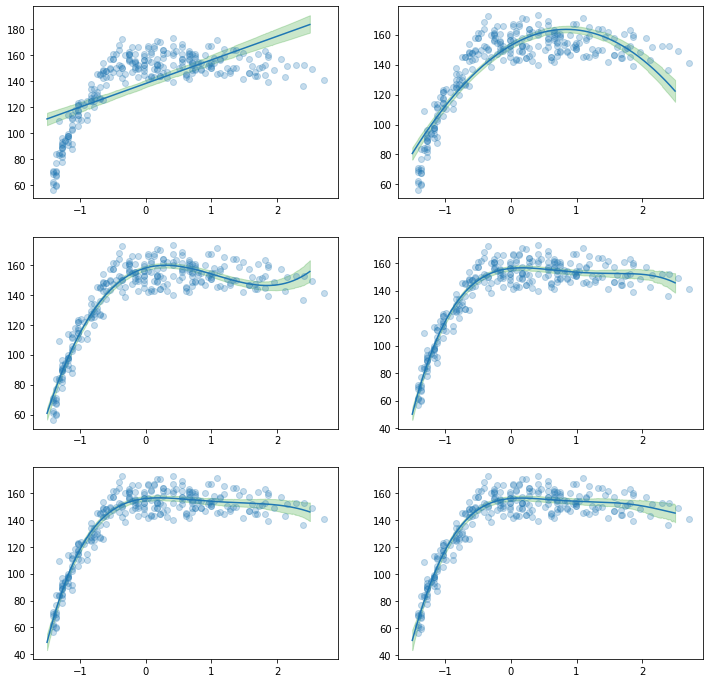

In [235]:
#7H2

x=np.linspace(-1.5, 2.5, 1000)
f = plt.figure(figsize=(12,12))

ax1=f.add_subplot(321)
ax1.plot(d1.age_std, d1.height, 'o', alpha=0.25)
mu_pred = trace_7H_1['alpha'] + trace_7H_1['beta_age'] * x[:,None]
ax1.plot(x, mu_pred.mean(1), 'C0')
mu_hpd = pm.hpd(mu_pred.T, alpha = 0.03)
ax1.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)

ax2=f.add_subplot(322)
ax2.plot(d1.age_std, d1.height, 'o', alpha=0.25)
mu_pred = (trace_7H_2['alpha'] + trace_7H_2['beta_age'][:,0]* x[:,None] 
           + trace_7H_2['beta_age'][:,1] * x[:,None]**2)
ax2.plot(x, mu_pred.mean(1), 'C0')
mu_hpd = pm.hpd(mu_pred.T, alpha = 0.03)
ax2.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)

ax3=f.add_subplot(323)
ax3.plot(d1.age_std, d1.height, 'o', alpha=0.25)
mu_pred = (trace_7H_3['alpha'] + trace_7H_3['beta_age'][:,0]* x[:,None] 
           + trace_7H_3['beta_age'][:,1] * x[:,None]**2 
           + trace_7H_3['beta_age'][:,2] * x[:,None]**3)
ax3.plot(x, mu_pred.mean(1), 'C0')
mu_hpd = pm.hpd(mu_pred.T, alpha = 0.03)
ax3.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)

ax4=f.add_subplot(324)
ax4.plot(d1.age_std, d1.height, 'o', alpha=0.25)
mu_pred = (trace_7H_4['alpha'] + trace_7H_4['beta_age'][:,0]* x[:,None] 
           + trace_7H_4['beta_age'][:,1] * x[:,None]**2 
           + trace_7H_4['beta_age'][:,2] * x[:,None]**3
           + trace_7H_4['beta_age'][:,3] * x[:,None]**4)
ax4.plot(x, mu_pred.mean(1), 'C0')
mu_hpd = pm.hpd(mu_pred.T, alpha = 0.03)
ax4.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)

ax5=f.add_subplot(325)
ax5.plot(d1.age_std, d1.height, 'o', alpha=0.25)
mu_pred = (trace_7H_5['alpha'] + trace_7H_5['beta_age'][:,0]* x[:,None] 
           + trace_7H_5['beta_age'][:,1] * x[:,None]**2 
           + trace_7H_5['beta_age'][:,2] * x[:,None]**3
           + trace_7H_5['beta_age'][:,3] * x[:,None]**4
           + trace_7H_5['beta_age'][:,4] * x[:,None]**5)
ax5.plot(x, mu_pred.mean(1), 'C0')
mu_hpd = pm.hpd(mu_pred.T, alpha = 0.03)
ax5.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)

ax6=f.add_subplot(326)
ax6.plot(d1.age_std, d1.height, 'o', alpha=0.25)
mu_pred = (trace_7H_6['alpha'] + trace_7H_6['beta_age'][:,0]* x[:,None] 
           + trace_7H_6['beta_age'][:,1] * x[:,None]**2 
           + trace_7H_6['beta_age'][:,2] * x[:,None]**3
           + trace_7H_6['beta_age'][:,3] * x[:,None]**4
           + trace_7H_6['beta_age'][:,4] * x[:,None]**5
           + trace_7H_6['beta_age'][:,5] * x[:,None]**6)
ax6.plot(x, mu_pred.mean(1), 'C0')
mu_hpd = pm.hpd(mu_pred.T, alpha = 0.03)
ax6.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);

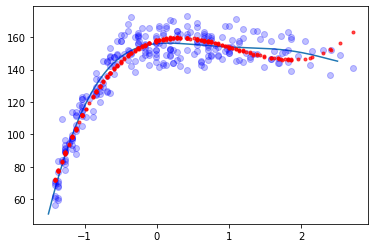

In [236]:
# 7H3
# It seems mean to ask about model averaging when the text specifically says it won't be
# covered in the book!

# https://docs.pymc.io/notebooks/model_averaging.html
# I'm not 100% sure if I'm doing this right.

traces = [trace_7H_1, trace_7H_2, trace_7H_3, trace_7H_4, trace_7H_5, trace_7H_6]
ppc_w = pm.sample_posterior_predictive_w(traces, 1000, [m_7H_1, m_7H_2, m_7H_3, m_7H_4, m_7H_5, m_7H_6],
                        weights=comp_WAIC.weight.sort_index(ascending=True),
                        progressbar=False)
# ppc_w will give 1000 samples, where each sample contains a predicted height for a given weight.

mean_predicted_heights = ppc_w['height'].mean(0)

x=np.linspace(-1.5, 2.5, 1000)
mu_pred = (trace_7H_6['alpha'] + trace_7H_6['beta_age'][:,0]* x[:,None] 
           + trace_7H_6['beta_age'][:,1] * x[:,None]**2 
           + trace_7H_6['beta_age'][:,2] * x[:,None]**3
           + trace_7H_6['beta_age'][:,3] * x[:,None]**4
           + trace_7H_6['beta_age'][:,4] * x[:,None]**5
           + trace_7H_6['beta_age'][:,5] * x[:,None]**6)
plt.plot(x, mu_pred.mean(1), 'C0')
plt.plot(d1.age_std, d1.height, 'ob', alpha=0.25)
plt.plot(d1.age_std, mean_predicted_heights, '.r', alpha=0.7);

# The average predictions seem a bit smoother, I guess? It looks like there are slightly
# fewer concavity changes near the tail end of the graph.

In [139]:
# 7H4
# Based on the above work, R code 7.21 and the next few

n_samples = 1000
n_observations = d2.shape[0]
logp = np.zeros((n_observations, n_samples))

for s in range(0,n_samples): # for each sample from the posterior we're checking
    mu = (trace_7H_1['alpha'][s] + trace_7H_1['beta_age'][s]* d2.age_std)
    p_ = stats.norm.logpdf(d2['height'], loc=mu, scale=trace_7H_1['sigma'][s]) # this is the way of getting the log value of the prediction. It must be a distribution, because everything in this world is a distribution.
    logp[:,s] = p_ # we end up with each row being a data point, and each column being a sample

n_cases = d2.shape[0] # number of rows in d2, e.g. number of data points
lppd = np.zeros((n_cases)) # I still don't understand why we have to fill this thing with zeros - maybe it's cleaner than just doing append
for a in range(0, n_cases):
    lppd[a,] = logsumexp(logp[a,]) - np.log(n_samples) # We have to do the averaging on the log scale. Not sure why - probably some computer science reason.

lppd_first = lppd.sum()
lppd_first

-1100.0529176456507

In [170]:
# Let's write a function to do this.

def calculate_deviance(trace, betas, n_samples, data, observations, name):
    try:
        if trace[betas].shape[1]:
            number_coefficients = trace[betas].shape[1]
    except IndexError:
        #pass
        number_coefficients = 1
    
    n_observations = data.shape[0]
    logp = np.zeros((n_observations, n_samples))
    for s in range(0,n_samples): # for each sample from the posterior we're checking
        mu = trace['alpha'][s]
        if number_coefficients>1:
            for i in range(0,number_coefficients):
                mu = mu + trace[betas][:,i][s]*data**(i+1)
        else: mu = mu + trace[betas][s]*data
        p_ = stats.norm.logpdf(observations, loc=mu, scale=trace['sigma'][s]) # this is the way of getting the log value of the prediction. It must be a distribution, because everything in this world is a distribution.
        logp[:,s] = p_ # we end up with each row being a data point, and each column being a sample
        
    n_cases = data.shape[0] # number of rows in d1, e.g. number of data points
    lppd = np.zeros((n_cases)) # I still don't understand why we have to fill this thing with zeros - maybe it's cleaner than just doing append
    for a in range(0, n_cases):
        lppd[a,] = logsumexp(logp[a,]) - np.log(n_samples) # We have to do the averaging on the log scale. Not sure why - probably some computer science reason.
    pWAIC = np.zeros((n_cases))
    for a in range(0, n_cases):
        pWAIC[a] = np.var(logp[a]) # This just computes the variance of each row in logp.
    
    WAIC = -2*(lppd.sum() - pWAIC.sum())
    return lppd.sum(), pWAIC.sum(), WAIC, name

In [171]:
lppd_first = calculate_deviance(trace_7H_1, 'beta_age', 1000, d2.age_std, d2.height, 'first order')
lppd_second = calculate_deviance(trace_7H_2, 'beta_age', 1000, d2.age_std, d2.height, 'second order')
lppd_third = calculate_deviance(trace_7H_3, 'beta_age', 1000, d2.age_std, d2.height, 'third order')
lppd_fourth = calculate_deviance(trace_7H_4, 'beta_age', 1000, d2.age_std, d2.height, 'fourth order')
lppd_fifth = calculate_deviance(trace_7H_5, 'beta_age', 1000, d2.age_std, d2.height, 'fifth order')
lppd_sixth = calculate_deviance(trace_7H_6, 'beta_age', 1000, d2.age_std, d2.height, 'sixth order')
lppds = [lppd_first, lppd_second, lppd_third, lppd_fourth, lppd_fifth, lppd_sixth]

In [172]:
# Now let's scale the deviances. We'll return a list of tuples in the form (WAIC, pWAIC, deviance)
l_min = lppds[0][0]
scaled_Ls = []
for l in lppds:
    if l[0] < l_min:
        l_min = l[0]
        
# l_min now has the smallest deviance

for l in lppds:
    x = l[0]-l_min
    scaled_Ls.append((l[3], l[2].round(2), l[1].round(2), x.round(2)))
scaled_Ls

# It seems like the model with the smallest WAIC score (4th order) has the biggest deviance for
# out-of-sample predictions. The model with the worst WAIC score (first order) has the 
# lowest deviance. The effects look reversed, but that's because I didn't make
# the deviance above negative, which is what happens in the WAIC formula. So we're good.
# Let's compare with the WAIC work done earlier, where we looked at in-sample data.

[('first order', 2206.05, 2.97, 0.0),
 ('second order', 1975.16, 7.1, 119.57),
 ('third order', 1781.53, 9.04, 218.33),
 ('fourth order', 1727.83, 5.44, 241.58),
 ('fifth order', 1734.21, 7.56, 240.51),
 ('sixth order', 1774.36, 27.41, 240.29)]

In [273]:
comp_WAIC
# There's the same pattern here. 

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
fourth order,1899.96,5.56,0,0.98,23.65,0,1
sixth order,1901.24,6.62,1.29,0,23.5,1.61,1
fifth order,1902.03,6.36,2.07,0,23.55,1.2,1
third order,1949.78,6.7,49.82,0,23.56,15.45,1
second order,2128.95,5.15,228.99,0.02,22.05,27.12,1
first order,2410.06,3.47,510.1,0,22.91,31.46,0
